In [1]:
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy
from models.model_helper import activation_helper


class MLP(nn.Module):
    def __init__(self, num_series, lag, hidden, activation):
        super(MLP, self).__init__()
        self.activation = nn.ReLU()

        # Set up network.
        layer = nn.Conv1d(num_series, hidden[0], lag)
        modules = [layer]

        for d_in, d_out in zip(hidden, hidden[1:] + [1]):
            layer = nn.Conv1d(d_in, d_out, 1)
            modules.append(layer)

        # Register parameters.
        self.layers = nn.ModuleList(modules)

    def forward(self, X):
        print('X.shape:', X.shape)
        X = X.transpose(2, 1)
        for i, fc in enumerate(self.layers):
            if i != 0:
                X = self.activation(X)
            X = fc(X)

        return X.transpose(2, 1)

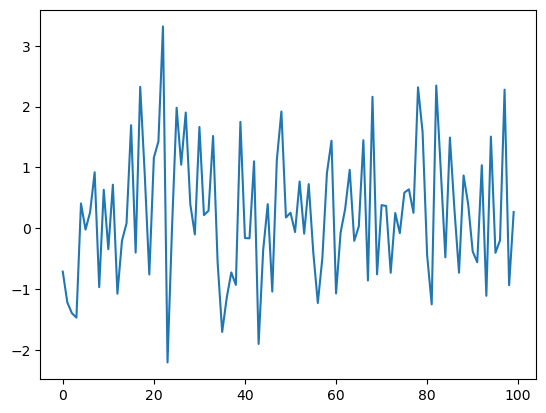

In [2]:
# generate a series of data with length 100, and shape 1, 1, 100
data = torch.randn(1, 100, 1)
# plot the data
import matplotlib.pyplot as plt
plt.plot(data[0, :, 0].numpy())
plt.show()

In [3]:
data.shape[-1]

1

X.shape: torch.Size([1, 100, 1])
output.shape: torch.Size([1, 98, 1])


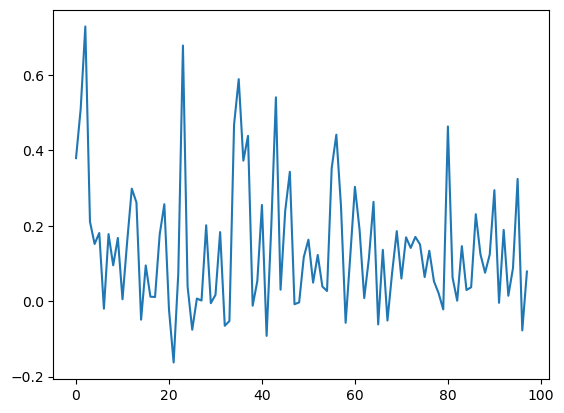

In [4]:
mlp = MLP(data.shape[-1], 3, [1000], 'relu')
output = mlp(data)
print('output.shape:', output.shape)

# plot the output
plt.plot(output[0, :, 0].detach().numpy())


X.shape: torch.Size([1, 100, 1])


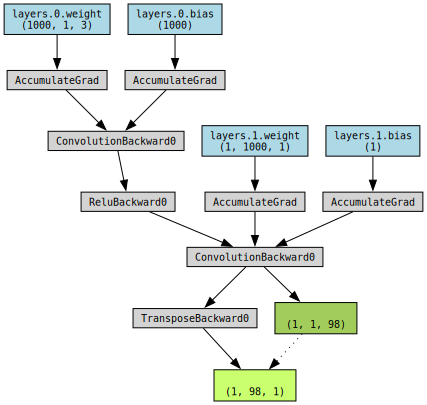

In [5]:
# visualize the network
import torchviz
x = torch.randn(1, 100, 1)
y = mlp(x)
torchviz.make_dot(y, params=dict(mlp.named_parameters()))